## to do

In [1]:
#Coord((0,0,1))->Coord(0,0,1)?

## translate mathematica codes

## setup grid

In [2]:
struct Coord{D}
    c::NTuple{D,Int}
end

In [3]:
Base.getindex(c::Coord, i) = c.c[i]

In [4]:
listGridSize=(3,3,5)

(3, 3, 5)

In [5]:
using LightGraphs
using GraphPlot

function gridGraph(m)
    sk = path_graph(listGridSize[length(listGridSize)])
    for i in length(listGridSize)-1:-1:1
       sk = cartesian_product(sk , path_graph(listGridSize[i]))
    end
    return sk
end

gridGraph (generic function with 1 method)

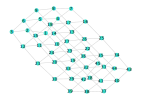

In [6]:
sk = gridGraph(0)
gplot(sk,nodelabel=1:nv(sk))

## grid objects

In [7]:
function gridSize(j)
    prod(listGridSize[1:j])
end

gridSize (generic function with 1 method)

In [8]:
function crd(m::Int)
    d = length(listGridSize)
    c = zeros(Int, d)
    m -= 1
    for i in 1:d
        c[i] = mod(m, listGridSize[i])
        m = fld(m, listGridSize[i])
    end
    @assert m == 0
    Coord(tuple(c...))
end

crd (generic function with 1 method)

In [9]:
function lbl(c::Coord{D}) where {D}
    m = 0
    for i in D:-1:1
        m = m * listGridSize[i] + c[i]
    end
    m + 1
end

lbl (generic function with 1 method)

In [10]:
crd(6)

Coord{3}((2, 1, 0))

In [11]:
lbl(Coord((0,1,0)))

4

In [12]:
all(lbl(crd(m)) == m for m in 1:gridSize(3))

true

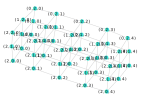

In [13]:
gplot(sk, nodelabel=[crd(i).c for i in 1:nv(sk)])

In [14]:
# function atom(c::NTuple{D,Int}) where {D}
#     c1 = NTuple{D,Int}[]
#     for offset in CartesianIndices(ntuple(i->2, D))
#         push!(c1, ntuple(i -> c[i] + offset.I[i]-1, D))
#     end
#     c1
# end

function atom(c::Coord{D}) where {D}
    c1 = Coord{D}[]
    for offset in CartesianIndices(ntuple(i->2, D))
        push!(c1, Coord(ntuple(i -> c[i] + offset.I[i]-1, D)))
    end
    c1
end

function atom(m::Int)
    [lbl(c) for c in atom(crd(m))]
end

atom (generic function with 2 methods)

In [15]:
atom(Coord((0,0,0)))

8-element Array{Coord{3},1}:
 Coord{3}((0, 0, 0))
 Coord{3}((1, 0, 0))
 Coord{3}((0, 1, 0))
 Coord{3}((1, 1, 0))
 Coord{3}((0, 0, 1))
 Coord{3}((1, 0, 1))
 Coord{3}((0, 1, 1))
 Coord{3}((1, 1, 1))

In [16]:
atom(3)

8-element Array{Int64,1}:
  3
  4
  6
  7
 12
 13
 15
 16

In [17]:
#refer to edge by (vertex, vertex)
struct Edgevv
    e::Tuple{Int,Int}
end

In [18]:
# function atomCorner(m::Int, n::Int)
#     # m labels atom, n labels vertex within atom
#     d = length(listGridSize)
#     crn = Tuple{Int,Int}[]
#     for i in 1:2^d
#         if sum(abs.([crd(atom(m)[n]).c...]-[crd(atom(m)[i]).c...]))==1
#             push!(crn, (atom(m)[n], atom(m)[i]))
#         end
#     end
#     crn
# end

function atomCorner(m::Int, n::Int)
    # m labels atom, n labels vertex within atom
    d = length(listGridSize)
    crn = Edgevv[]
    for i in 1:2^d
        if sum(abs.([crd(atom(m)[n]).c...]-[crd(atom(m)[i]).c...]))==1
            push!(crn, Edgevv((atom(m)[n], atom(m)[i])))
        end
    end
    crn
end

function atomCorner(c::Coord{D}, n::Int) where {D}
    crn = Tuple{Coord{D},Coord{D}}[]
    for i in 1:2^D
        if sum(abs.([atom(c)[n].c...]-[atom(c)[i].c...]))==1
            push!(crn, (atom(c)[n], atom(c)[i]))
        end
    end
    crn
end

atomCorner (generic function with 2 methods)

In [19]:
atomCorner(2,1)

3-element Array{Edgevv,1}:
 Edgevv((2, 3)) 
 Edgevv((2, 5)) 
 Edgevv((2, 11))

In [20]:
atomCorner(Coord((0,0,1)),1)

3-element Array{Tuple{Coord{3},Coord{3}},1}:
 (Coord{3}((0, 0, 1)), Coord{3}((1, 0, 1)))
 (Coord{3}((0, 0, 1)), Coord{3}((0, 1, 1)))
 (Coord{3}((0, 0, 1)), Coord{3}((0, 0, 2)))

## amplitude

In [21]:
function vvmd(s,c,d)
    if s == 0
        return 1.0
    elseif c == 0
        return d/s
    else
        return (sinc(s*sqrt(c/d)/pi))^(-d)
    end
end

vvmd (generic function with 1 method)

In [22]:
#refer to edge by (vertex,direction)
struct Edgevd
    e::Tuple{Int,Int}
end

In [23]:
#refer to edge by a vertice m and a direction dr
# function ampEdge(svalue,cvalue,m,dr,L,d)
#     if svalue[m,dr] == 0
#         return 1
#     else
#         vd = vvmd(svalue[m,dr],cvalue[m,dr],d)
#         return vd^(3/vd)*exp(-L*svalue[m,dr]/vd)
#     end
# end

function ampEdge(svalue,cvalue,evd::Edgevd,L,d)
    m, dr = evd.e
    if svalue[m,dr] == 0
        return 1
    else
        vd = vvmd(svalue[m,dr],cvalue[m,dr],d)
        return vd^(3/vd)*exp(-L*svalue[m,dr]/vd)
    end
end

ampEdge (generic function with 1 method)

In [24]:
svalue=fill(1.0,(gridSize(length(listGridSize)),length(listGridSize)))
cvalue=fill(0.0,(gridSize(length(listGridSize)),length(listGridSize)));

In [26]:
function direction(e::Edgevv)
    d = length(listGridSize)
    #e=(m,n) refers to edge by vertices
    m,n = e.e
    mc = crd(m)
    nc = crd(n)
    dist = abs.(mc.c .- nc.c)
    for i in 1:d
        if dist == ntuple(j -> i==j, d)
            return i
        end
    end
    @assert false
end

#edge (vertices) to edge (vertex,direction)
function edgeVD(evv::Edgevv)
    return Edgevd(((min(evv.e...),direction(evv))))
end

edgeVD (generic function with 1 method)

In [27]:
direction(Edgevv((1,10)))

3

In [28]:
edgeVD(Edgevv((1,4)))

Edgevd((1, 2))

In [25]:
ampEdge(svalue,cvalue,Edgevd((2,1)),2,3)

1.540251357097776

In [29]:
#(m,n) label corners. in 3d n=1,...,8
function expCorner(svalue, m::Int, n::Int, a)
    d = length(listGridSize)
    a * prod(svalue[edgeVD(atomCorner(m,n)[i]).e...] for i in 1:d)
end

expCorner (generic function with 1 method)

In [30]:
expCorner(svalue,2,2,2)

2.0

In [31]:
function ampCorner(svalue, cvalue, m::Int, n::Int,a,L,d)
    p = 1.0
    for i in 1:d
        ss = svalue[edgeVD(atomCorner(m,n)[i]).e...]
        p *= ampEdge(svalue, cvalue, edgeVD(atomCorner(m,n)[i]),L,d)^(expCorner(svalue, m, n, a) / ss)
    end
    return p
    #prod([ampEdge(edgeVD(atomCorner(m,n)[i])...,L,d)^(expCorner(m, n, a) * s[edgeVD(atomCorner(m,n)[i])...]^(-1)) for i in 1:length(listGridSize)])
end

ampCorner (generic function with 1 method)

In [32]:
ampCorner(svalue,cvalue,2,2,1,0,3)

27.0

### total amplitude

In [35]:
function ampVG(a,L,d)
    lgs = listGridSize  
    las = lgs.- 1    
    p = 1.0
    for i in 1:prod(las), j in 1:2^d
        #albl=atomlabel[i]
        albl = lbl(Coord(CartesianIndices(las)[i].I.-1))
        p *= ampCorner(svalue, cvalue, albl, j, a, L, d)
    end
    return p
end 

ampVG (generic function with 1 method)

In [36]:
lgs = listGridSize
D = length(listGridSize)
las=lgs.-1

(2, 2, 4)

In [37]:
[lbl(Coord(map(-,CartesianIndices(las)[i].I,ntuple(i->1,D)))) for i in 1:prod(las)]

16-element Array{Int64,1}:
  1
  2
  4
  5
 10
 11
 13
 14
 19
 20
 22
 23
 28
 29
 31
 32

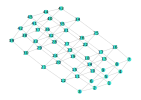

In [38]:
gplot(sk,nodelabel=1:nv(sk))

In [43]:
ampVG(1,3.3,3)

0.5869115502892437

## check with Mathematica

In [40]:
svalue=fill(1.0,(gridSize(length(listGridSize)),length(listGridSize)))
cvalue=fill(0.0,(gridSize(length(listGridSize)),length(listGridSize)));

In [53]:
edgeVD(Edgevv((1,2))).e
edgeVD(Edgevv((1,10))).e

(1, 3)

In [59]:
svalue[edgeVD(Edgevv((1,2))).e...]=2
svalue[edgeVD(Edgevv((1,10))).e...]=2.5
svalue

45×3 Array{Float64,2}:
 2.0  1.0  2.5
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 ⋮            
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0

In [57]:
ampVG(1,3,3)

18321.815352388578

In [58]:
cvalue[edgeVD(Edgevv((1,2))).e...]=1
cvalue[edgeVD(Edgevv((1,10))).e...]=.5
cvalue

45×3 Array{Float64,2}:
 1.0  0.0  0.5
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 ⋮            
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [60]:
ampVG(1,3,3)

1.7704410683795636e9

In [ ]:
------------

In [33]:
atomCorner(2,2)

3-element Array{Edgevv,1}:
 Edgevv((3, 2)) 
 Edgevv((3, 6)) 
 Edgevv((3, 12))

In [34]:
ampCorner(svalue, cvalue,2,2,1,2,3)

3.6540526473885424